In [44]:
import os
import pandas as pd 
import numpy as np
from nltk import WordNetLemmatizer
from nltk import PorterStemmer
from nltk.corpus import stopwords
from nltk import WordPunctTokenizer
import math
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from collections import Counter
from sklearn.metrics import log_loss
from scipy.spatial.distance import cdist
import random
import enchant
import seaborn as sns
import copy
import warnings
warnings.filterwarnings('ignore')
random.seed(1)
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4]
sns.set(style = "darkgrid")

%run fns.ipynb

In [27]:
stop_ws = set(stopwords.words('english'))
d = enchant.Dict("en_US")
path = "dataset/"
renamed = False

In [28]:
# if(not renamed):
#     rename_documents(path)
#     renamed = True

#doc id start from 1
docs, docs_label, label_mapped = collect_documents(path)

C = 5

{'talk.politics.misc': 0, 'sci.med': 1, 'sci.space': 2, 'comp.graphics': 3, 'rec.sport.hockey': 4}


In [29]:
data = pd.DataFrame.from_dict(docs, orient = 'index', columns = ['text'])
data['doc_id'] = data.index.astype(str).astype(int)
data['class'] = docs_label
data = data.sample(frac=1).reset_index(drop=True)

In [30]:
def joinList(inputList):
    return " ".join(inputList)  

In [31]:
def applyPreprocessing(data, col_name):
    data[col_name] = data[col_name].apply(tokenizeDocument)
    data[col_name] = data[col_name].apply(joinList)
  
    return data[col_name]

In [32]:
data['text'] = applyPreprocessing(data, 'text')
data.head()

,text,doc_id,class
0,comp graphic path cantaloupe com an net gov co...,587,3
1,cantaloupe com an net destroyer ca ca ca ac ca...,2681,4
2,cantaloupe sci space sci bio newsgroups sci sp...,4744,2
3,cantaloupe magnesium club cc news state mp sta...,731,3
4,cantaloupe magnesium club cc news state mp sta...,2073,4


In [33]:
def getBagofwords(data, col_name):
    vectorizer = CountVectorizer(analyzer = 'word')
    bow = vectorizer.fit_transform(data[col_name])
    return vectorizer, bow


def featureNameToIndex(B,feat):
    return B.vocabulary_.get(feat)

In [34]:
def getVectors(d):
    vectorizer_content, X  = getBagofwords(d, 'text')

    print('Total no. of documents : ', X.shape[0])
    print('Total no. of features (full text) : ', X.shape[1])
    
    X = X.toarray()
    X = X * (1/np.linalg.norm(X, axis = 1))[:, np.newaxis]
    
    return X

In [35]:
X = getVectors(data)

Total no. of documents :  5000
Total no. of features (full text) :  19714


In [36]:
split_percentage = 90 # train set %
nr = int((split_percentage/100)*X.shape[0])
X_train = X[:nr, :]
y_train = data['class'].iloc[:nr].values

X_test = X[nr:, :]
y_test = data['class'].iloc[nr:].values

In [37]:
print('Training Set : ', X_train.shape)
print('Training Set labels : ', y_train.shape)
print('Test Set : ', X_test.shape)
print('Test Set labels : ', y_test.shape)

Training Set :  (4500, 19714)
Training Set labels :  (4500,)
Test Set :  (500, 19714)
Test Set labels :  (500,)


In [38]:
def kNN(k, x_train, x_test, y_train):
    predicted_labels = []
    
    prob_mat = np.zeros((x_test.shape[0], C)) # 1500 x C
    
    dist_mat = np.zeros((x_test.shape[0], x_train.shape[0]))
    
    for i in tqdm_notebook(range(0, x_test.shape[0])):
        dist_mat[i, :] = cdist(x_train, x_test[i, :][np.newaxis,  :], 'euclidean').ravel()
        pos = dist_mat[i,:].argsort()[:k]
        unq, cnt = np.unique(y_train[pos], return_counts = True) # prob for ROC
        for c in range(0, unq.shape[0]):
            prob_mat[i, unq[c]] = cnt[c]/k
        
    predicted_labels = np.argmax(prob_mat, axis = 1)
    
    return predicted_labels, prob_mat

### Confusion Matrix, Accuracy and ROC


Log loss : 2.8321796643826804
Accuracy using k =  1 ,  90:10 91.8 %.


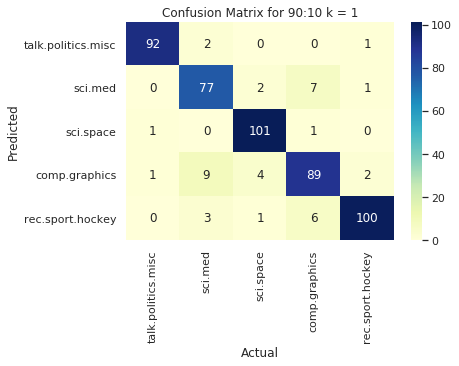

     class       FPR       TPR
0      0.0  1.000000  1.000000
1      0.0  0.007389  0.978723
2      0.0  0.007389  0.978723
3      0.0  0.007389  0.978723
4      0.0  0.007389  0.978723
5      0.0  0.007389  0.978723
6      0.0  0.007389  0.978723
7      0.0  0.007389  0.978723
8      0.0  0.007389  0.978723
9      0.0  0.007389  0.978723
10     0.0  0.007389  0.978723
11     0.0  0.007389  0.978723
12     0.0  0.007389  0.978723
13     0.0  0.007389  0.978723
14     0.0  0.007389  0.978723
15     0.0  0.007389  0.978723
16     0.0  0.007389  0.978723
17     0.0  0.007389  0.978723
18     0.0  0.007389  0.978723
19     0.0  0.007389  0.978723
20     0.0  0.007389  0.978723
21     0.0  0.007389  0.978723
22     0.0  0.007389  0.978723
23     0.0  0.007389  0.978723
24     0.0  0.007389  0.978723
25     0.0  0.007389  0.978723
26     0.0  0.007389  0.978723
27     0.0  0.007389  0.978723
28     0.0  0.007389  0.978723
29     0.0  0.007389  0.978723
..     ...       ...       ...
470    4

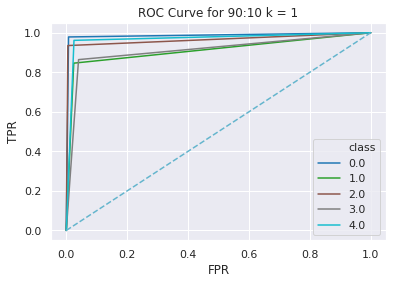

In [46]:
# k = list(range(1,20,2))
k = [1]
log_ls = []
acc = []

for v in k:
    predict, probab_mat = kNN(v, X_train, X_test, y_train)
    conf_mat = confusionMatrix(predict, y_test)
    
    print('Log loss :', log_loss(y_test, probab_mat))
    log_ls.append(log_loss(y_test, probab_mat))
    
    accuracy = (np.trace(conf_mat)/np.sum(conf_mat))*100
    acc.append(accuracy)
    
    print('Accuracy using k = ',v,', ', str(split_percentage) +':'+ str(100 - split_percentage), accuracy, '%.')
    
    drawConfusionMatrix(conf_mat, label_mapped, str(split_percentage) +':'+ str(100 - split_percentage) + ' k = ' + str(v))
    ROC(y_test, probab_mat, str(split_percentage) +':'+ str(100 - split_percentage) + ' k = ' + str(v))